In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm

import zarr
import xarray as xr
import os
from sklearn import preprocessing

import torch
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.utils.data as data_utils
from torch.nn import Linear, Conv1d, ConvTranspose1d

from torch.nn import Sequential as Seq, Linear as Lin, ReLU, Sigmoid, ConstantPad1d
from torch.functional import F
from torch.optim.lr_scheduler import OneCycleLR, ReduceLROnPlateau, CosineAnnealingWarmRestarts
from tqdm import tqdm

from tqdm.notebook import tqdm
from sklearn.neighbors import NearestNeighbors
import json

In [6]:
from models import DriverDatasets, MicroAutoEncoder
#from visualization import latentvars

In [3]:
!pip install scikit-dimension

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 319.8 kB/s eta 0:00:000:00:01


In [7]:
from skdim.id import MiND_ML, DANCo, MLE, MOM

## Load the Data Sets

In [8]:
trainloader=torch.load('/home/jovyan/neural-dsds/neural-dsds/data/trainloader_onecat.pth')
valloader=torch.load('/home/jovyan/neural-dsds/neural-dsds/data/valloader_onecat.pth')
testloader=torch.load('/home/jovyan/neural-dsds/neural-dsds/data/testloader_onecat.pth')

In [9]:
model = MicroAutoEncoder(n_latent=10)

ii = 0 
for data in trainloader:
    M,dMdt,bin0,bin1coal,bin1condevap,binmag,M1,dM1dt,M2,dM2dt=data
    print(bin0.shape)
    print(M.shape,bin0.shape)
    xhat,latent = model(bin0.float())

    ii+=1
    if ii >2: 
        break

torch.Size([500, 2, 35])
torch.Size([500, 4, 3]) torch.Size([500, 2, 35])
torch.Size([500, 2, 35])
torch.Size([500, 4, 3]) torch.Size([500, 2, 35])
torch.Size([500, 2, 35])
torch.Size([500, 4, 3]) torch.Size([500, 2, 35])


## Train the Model

In [10]:
def recon_loss(recon_x,x):
    mseloss = torch.nn.MSELoss()

    mse = mseloss(recon_x,x)

    return mse

In [11]:
def train(model,dataloader,criterion,device,epoch):
    model.train()
    
    for data in dataloader:
        M,dMdt,bin0,bin1coal,bin1condevap,binmag,M1,dM1dt,M2,dM2dt=data
        bin1 = bin1coal #bin1condevap #

        bin0 = bin0.to(device)
        bin1 = bin1.to(device)
        optimizer.zero_grad()

        xhat,latent = model(bin0.float())
        
        
        mseloss = recon_loss(xhat,bin1.float())
    
        loss = mseloss
        
        loss.backward()

        optimizer.step()
        
    return model
def test(model,dataloader,criterion,device,val=False):
    model.eval()
    correct = 0
    recon = 0

    with torch.no_grad():
        for data in dataloader:
            M,dMdt,bin0,bin1coal,bin1condevap,binmag,M1,dM1dt,M2,dM2dt=data
            bin1 = bin1coal #bin1condevap #
            bin0 = bin0.to(device)
            bin1 = bin1.to(device)
            
            xhat,latent = model(bin0.float())

            mse = recon_loss(xhat.float(),bin1.float())
            
            #correct = correct+loss
            nn = len(dataloader.dataset)
            recon = recon+mse

                        
        if val==True:
            sched.step(recon/nn)
            
        return recon/nn

def inference(model,dataloader,device):
    model.eval()
    dataset = dataloader.dataset
    ntargets = 4
    nrates = 3
    bs = 500
    
    pred = np.zeros((len(dataset)*bs,ntargets,nrates))
    real = np.zeros((len(dataset)*bs,ntargets,nrates))
    realbin1 = np.zeros((len(dataset)*bs,2,35))
    realbin0 = np.zeros((len(dataset)*bs,2,35))
    predbin1 = np.zeros((len(dataset)*bs,2,35))
    predM = np.zeros((len(dataset)*bs,ntargets))
    realM = np.zeros((len(dataset)*bs,ntargets))

    jj = 0
    i = 0

    for data in dataloader:

        M,dMdt,bin0,bin1coal,bin1condevap,binmag,M1,dM1dt,M2,dM2dt=data
        bin1 = bin1coal 
        
        xhat,latent = model(bin0.float())
        
        bs = xhat.shape[0]
        if xhat is not(None):
            realbin0[jj:jj+bs,:]=bin0.cpu().detach().numpy().reshape(bs,2,35)
            realbin1[jj:jj+bs,:]=bin1.cpu().detach().numpy().reshape(bs,2,35)
            predbin1[jj:jj+bs,:]=xhat.cpu().detach().numpy().reshape(bs,2,35)
            
            jj=jj+bs
            i = i+1
        else:
            break

    return realbin1,predbin1,realbin0

In [12]:
nlat = [2,3,4,5,8,10,12,14,18,20]

In [13]:
torch.cuda.current_device()

0

In [15]:
for j in nlat:
    print("Training model nlat = ",str(j))
    init_lr = 1e-3
    weight_decay = 1e-3
    total_epochs = 1000

    # Learning rate strings so its in the correct format for the filenames
    lrval='{:3.0e}'.format(init_lr)[0]
    lrexp = '{:3.0e}'.format(init_lr)[4]

    model = MicroAutoEncoder(n_latent=j)

    # Check if there is a gpu
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=init_lr, weight_decay=weight_decay)
    criterion = torch.nn.MSELoss()
    sched =  ReduceLROnPlateau(optimizer, 'min')
    
    val_accur = []
    train_accur = []

    train_mse_recs = []
    val_mse_recs = []
    
    e0 = 0
    epochs = 1000
    best_epoch = 0
    
    min_loss = 1e10

    for epoch in tqdm(range(e0,epochs)):
        mod = train(model,trainloader,criterion,device,epoch)
        train_mse = test(model,trainloader,criterion,device)
        val_mse = test(model,valloader,criterion,device,val=True)

        train_mse_recs.append(train_mse)
        val_mse_recs.append(val_mse)
        if epoch%20 == 0:
            print(f'Epoch: {epoch:03d}, Train MSE: {train_mse:.8e}, Val. MSE: {val_mse:.8e}')
        if val_mse<min_loss:
            bestmodel = model
            min_loss = val_mse
            best_epoch = epoch
    
    tmp_trainloss = "IDModels/AE_z{}_mse_{}epochs_losses_updatedata.npz".format(j,epochs)
    tmp_valloss = "IDModels/AE_z{}_mse_{}epochs_valloss_updatedata.npz".format(j,epochs)
    mod_weights = "IDModels/AE_z{}_mse_{}epochs_updatedata".format(j,epochs)
    
    print(tmp_trainloss)
    print(tmp_valloss)
    print(mod_weights)
    print(best_epoch)
    
    torch.save(bestmodel.state_dict(),mod_weights)
    
    train_mse_np = np.array([train_mse_recs[i].detach().cpu().numpy() for i in range(0,len(train_mse_recs))])
    val_mse_np = np.array([val_mse_recs[i].detach().cpu().numpy() for i in range(0,len(val_mse_recs))])

    np.savez(tmp_trainloss,trainl=train_mse_np,vall=val_mse_np)

Training model nlat =  2


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 000, Train MSE: 1.35731525e-05, Val. MSE: 1.35853852e-05
Epoch: 020, Train MSE: 1.92297784e-06, Val. MSE: 1.93293295e-06
Epoch: 040, Train MSE: 9.83005975e-07, Val. MSE: 1.00200282e-06
Epoch: 060, Train MSE: 6.86499561e-07, Val. MSE: 7.07015090e-07
Epoch: 080, Train MSE: 5.99901455e-07, Val. MSE: 6.19257378e-07
Epoch: 100, Train MSE: 5.27177292e-07, Val. MSE: 5.42037355e-07
Epoch: 120, Train MSE: 4.93782181e-07, Val. MSE: 5.09456413e-07
Epoch: 140, Train MSE: 4.62902165e-07, Val. MSE: 4.78913705e-07
Epoch: 160, Train MSE: 4.45907972e-07, Val. MSE: 4.62656118e-07
Epoch: 180, Train MSE: 4.18634642e-07, Val. MSE: 4.35803287e-07
Epoch: 200, Train MSE: 4.09570362e-07, Val. MSE: 4.26941511e-07
Epoch: 220, Train MSE: 4.07022213e-07, Val. MSE: 4.24798316e-07
Epoch: 240, Train MSE: 3.87871836e-07, Val. MSE: 4.05941762e-07
Epoch: 260, Train MSE: 3.82483421e-07, Val. MSE: 4.01092819e-07
Epoch: 280, Train MSE: 3.77807652e-07, Val. MSE: 3.95954004e-07
Epoch: 300, Train MSE: 3.75968398e-07, V

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 000, Train MSE: 1.38136538e-05, Val. MSE: 1.38235564e-05
Epoch: 020, Train MSE: 1.20861682e-06, Val. MSE: 1.22518475e-06
Epoch: 040, Train MSE: 8.35653282e-07, Val. MSE: 8.54984989e-07
Epoch: 060, Train MSE: 7.21853098e-07, Val. MSE: 7.36838786e-07
Epoch: 080, Train MSE: 6.89141814e-07, Val. MSE: 7.04714864e-07
Epoch: 100, Train MSE: 6.03622595e-07, Val. MSE: 6.18386593e-07
Epoch: 120, Train MSE: 5.74697765e-07, Val. MSE: 5.89413560e-07
Epoch: 140, Train MSE: 5.56053067e-07, Val. MSE: 5.68920370e-07
Epoch: 160, Train MSE: 4.86305225e-07, Val. MSE: 4.99163377e-07
Epoch: 180, Train MSE: 4.32307075e-07, Val. MSE: 4.44658667e-07
Epoch: 200, Train MSE: 3.73566564e-07, Val. MSE: 3.87537511e-07
Epoch: 220, Train MSE: 3.45163329e-07, Val. MSE: 3.59379811e-07
Epoch: 240, Train MSE: 3.26392126e-07, Val. MSE: 3.40208516e-07
Epoch: 260, Train MSE: 3.20453040e-07, Val. MSE: 3.34381326e-07
Epoch: 280, Train MSE: 3.09876384e-07, Val. MSE: 3.23642723e-07
Epoch: 300, Train MSE: 3.00387001e-07, V

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 000, Train MSE: 1.36710196e-05, Val. MSE: 1.36837489e-05
Epoch: 020, Train MSE: 3.78627806e-06, Val. MSE: 3.82695816e-06
Epoch: 040, Train MSE: 2.67095493e-06, Val. MSE: 2.68957365e-06
Epoch: 060, Train MSE: 2.50237463e-06, Val. MSE: 2.52322525e-06
Epoch: 080, Train MSE: 2.46032459e-06, Val. MSE: 2.48155288e-06
Epoch: 100, Train MSE: 2.42699571e-06, Val. MSE: 2.44844387e-06
Epoch: 120, Train MSE: 2.40946929e-06, Val. MSE: 2.43034037e-06
Epoch: 140, Train MSE: 2.41446355e-06, Val. MSE: 2.43534123e-06
Epoch: 160, Train MSE: 1.82189285e-06, Val. MSE: 1.84007376e-06
Epoch: 180, Train MSE: 9.26317853e-07, Val. MSE: 9.43588930e-07
Epoch: 200, Train MSE: 6.05495643e-07, Val. MSE: 6.18965089e-07
Epoch: 220, Train MSE: 5.94281744e-07, Val. MSE: 6.08305015e-07
Epoch: 240, Train MSE: 5.80058156e-07, Val. MSE: 5.93706147e-07
Epoch: 260, Train MSE: 4.89806155e-07, Val. MSE: 5.00699628e-07
Epoch: 280, Train MSE: 4.21693670e-07, Val. MSE: 4.33088388e-07
Epoch: 300, Train MSE: 3.61830814e-07, V

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 000, Train MSE: 1.48140280e-05, Val. MSE: 1.48284080e-05
Epoch: 020, Train MSE: 7.44841600e-07, Val. MSE: 7.59871739e-07
Epoch: 040, Train MSE: 4.69216786e-07, Val. MSE: 4.84281259e-07
Epoch: 060, Train MSE: 3.97592061e-07, Val. MSE: 4.11585063e-07
Epoch: 080, Train MSE: 3.61420348e-07, Val. MSE: 3.75607613e-07
Epoch: 100, Train MSE: 3.37589967e-07, Val. MSE: 3.51310092e-07
Epoch: 120, Train MSE: 3.23441185e-07, Val. MSE: 3.37225231e-07
Epoch: 140, Train MSE: 2.99787018e-07, Val. MSE: 3.12962356e-07
Epoch: 160, Train MSE: 2.89009080e-07, Val. MSE: 3.02324793e-07
Epoch: 180, Train MSE: 2.82160443e-07, Val. MSE: 2.94975990e-07
Epoch: 200, Train MSE: 2.21510803e-07, Val. MSE: 2.34183702e-07
Epoch: 220, Train MSE: 2.14245489e-07, Val. MSE: 2.26205728e-07
Epoch: 240, Train MSE: 2.10533130e-07, Val. MSE: 2.22191886e-07
Epoch: 260, Train MSE: 2.04149913e-07, Val. MSE: 2.16049102e-07
Epoch: 280, Train MSE: 1.99859983e-07, Val. MSE: 2.11541845e-07
Epoch: 300, Train MSE: 1.99106822e-07, V

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 000, Train MSE: 1.31020752e-05, Val. MSE: 1.31109000e-05
Epoch: 020, Train MSE: 1.25976726e-06, Val. MSE: 1.26712769e-06
Epoch: 040, Train MSE: 4.69975390e-07, Val. MSE: 4.86259864e-07
Epoch: 060, Train MSE: 3.46952106e-07, Val. MSE: 3.64201554e-07
Epoch: 080, Train MSE: 2.87501734e-07, Val. MSE: 3.03851465e-07
Epoch: 100, Train MSE: 2.25385151e-07, Val. MSE: 2.39793280e-07
Epoch: 120, Train MSE: 1.93072097e-07, Val. MSE: 2.05501962e-07
Epoch: 140, Train MSE: 1.67605180e-07, Val. MSE: 1.77271019e-07
Epoch: 160, Train MSE: 1.53089587e-07, Val. MSE: 1.62045211e-07
Epoch: 180, Train MSE: 1.43046009e-07, Val. MSE: 1.51160677e-07
Epoch: 200, Train MSE: 1.37050421e-07, Val. MSE: 1.45345737e-07
Epoch: 220, Train MSE: 1.29665992e-07, Val. MSE: 1.37626913e-07
Epoch: 240, Train MSE: 1.23098417e-07, Val. MSE: 1.30844384e-07
Epoch: 260, Train MSE: 1.23320532e-07, Val. MSE: 1.30771937e-07
Epoch: 280, Train MSE: 1.14695808e-07, Val. MSE: 1.22048320e-07
Epoch: 300, Train MSE: 1.11035277e-07, V

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 000, Train MSE: 1.43348625e-05, Val. MSE: 1.43461384e-05
Epoch: 020, Train MSE: 1.21982123e-06, Val. MSE: 1.23232610e-06
Epoch: 040, Train MSE: 6.16427599e-07, Val. MSE: 6.32956528e-07
Epoch: 060, Train MSE: 3.62981865e-07, Val. MSE: 3.79710571e-07
Epoch: 080, Train MSE: 2.58715971e-07, Val. MSE: 2.73991645e-07
Epoch: 100, Train MSE: 2.15862727e-07, Val. MSE: 2.30193081e-07
Epoch: 120, Train MSE: 1.78407987e-07, Val. MSE: 1.91441487e-07
Epoch: 140, Train MSE: 1.57396443e-07, Val. MSE: 1.68174424e-07
Epoch: 160, Train MSE: 1.41939864e-07, Val. MSE: 1.50653491e-07
Epoch: 180, Train MSE: 1.28386176e-07, Val. MSE: 1.36627676e-07
Epoch: 200, Train MSE: 1.23554898e-07, Val. MSE: 1.30683148e-07
Epoch: 220, Train MSE: 1.13254394e-07, Val. MSE: 1.19964440e-07
Epoch: 240, Train MSE: 1.06622878e-07, Val. MSE: 1.12807868e-07
Epoch: 260, Train MSE: 1.01399223e-07, Val. MSE: 1.07310036e-07
Epoch: 280, Train MSE: 9.56821538e-08, Val. MSE: 1.01350132e-07
Epoch: 300, Train MSE: 9.52774428e-08, V

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 000, Train MSE: 1.40264765e-05, Val. MSE: 1.40387383e-05
Epoch: 020, Train MSE: 9.38926235e-07, Val. MSE: 9.59552494e-07
Epoch: 040, Train MSE: 4.89924844e-07, Val. MSE: 5.14600288e-07
Epoch: 060, Train MSE: 3.65635145e-07, Val. MSE: 3.87144411e-07
Epoch: 080, Train MSE: 2.77124684e-07, Val. MSE: 2.92173269e-07
Epoch: 100, Train MSE: 2.26434778e-07, Val. MSE: 2.39380171e-07
Epoch: 120, Train MSE: 1.96092458e-07, Val. MSE: 2.07995512e-07
Epoch: 140, Train MSE: 1.71438515e-07, Val. MSE: 1.82266163e-07
Epoch: 160, Train MSE: 1.55608149e-07, Val. MSE: 1.64630293e-07
Epoch: 180, Train MSE: 1.42549140e-07, Val. MSE: 1.50551870e-07
Epoch: 200, Train MSE: 1.34081517e-07, Val. MSE: 1.41070288e-07
Epoch: 220, Train MSE: 1.28620471e-07, Val. MSE: 1.35551730e-07
Epoch: 240, Train MSE: 1.24111850e-07, Val. MSE: 1.30465551e-07
Epoch: 260, Train MSE: 1.17039043e-07, Val. MSE: 1.23352834e-07
Epoch: 280, Train MSE: 1.14871632e-07, Val. MSE: 1.20981568e-07
Epoch: 300, Train MSE: 1.13074577e-07, V

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 000, Train MSE: 1.50129636e-05, Val. MSE: 1.50252690e-05
Epoch: 020, Train MSE: 8.90905255e-07, Val. MSE: 9.03229420e-07
Epoch: 040, Train MSE: 4.82619214e-07, Val. MSE: 5.01662214e-07
Epoch: 060, Train MSE: 3.92052016e-07, Val. MSE: 4.09952918e-07
Epoch: 080, Train MSE: 3.44892129e-07, Val. MSE: 3.60477856e-07
Epoch: 100, Train MSE: 3.14548203e-07, Val. MSE: 3.28188548e-07
Epoch: 120, Train MSE: 2.29659307e-07, Val. MSE: 2.42176725e-07
Epoch: 140, Train MSE: 2.06667707e-07, Val. MSE: 2.16370367e-07
Epoch: 160, Train MSE: 1.95003537e-07, Val. MSE: 2.01942214e-07
Epoch: 180, Train MSE: 1.87353564e-07, Val. MSE: 1.92849697e-07
Epoch: 200, Train MSE: 1.73613174e-07, Val. MSE: 1.78841859e-07
Epoch: 220, Train MSE: 1.66505217e-07, Val. MSE: 1.71810029e-07
Epoch: 240, Train MSE: 1.45419477e-07, Val. MSE: 1.51273071e-07
Epoch: 260, Train MSE: 1.39976549e-07, Val. MSE: 1.45447316e-07
Epoch: 280, Train MSE: 1.35164882e-07, Val. MSE: 1.40470405e-07
Epoch: 300, Train MSE: 1.32756213e-07, V

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 000, Train MSE: 1.42016934e-05, Val. MSE: 1.42211366e-05
Epoch: 020, Train MSE: 1.99890997e-06, Val. MSE: 2.01772082e-06
Epoch: 040, Train MSE: 8.03113039e-07, Val. MSE: 8.16172133e-07
Epoch: 060, Train MSE: 4.52148242e-07, Val. MSE: 4.66424609e-07
Epoch: 080, Train MSE: 3.27667493e-07, Val. MSE: 3.40278035e-07
Epoch: 100, Train MSE: 2.53708464e-07, Val. MSE: 2.66474757e-07
Epoch: 120, Train MSE: 2.20558746e-07, Val. MSE: 2.32392310e-07
Epoch: 140, Train MSE: 1.91806564e-07, Val. MSE: 2.02314965e-07
Epoch: 160, Train MSE: 1.80520175e-07, Val. MSE: 1.89658408e-07
Epoch: 180, Train MSE: 1.68216800e-07, Val. MSE: 1.75991360e-07
Epoch: 200, Train MSE: 1.58834737e-07, Val. MSE: 1.66349167e-07
Epoch: 220, Train MSE: 1.47237998e-07, Val. MSE: 1.54403736e-07
Epoch: 240, Train MSE: 1.41294109e-07, Val. MSE: 1.48095822e-07
Epoch: 260, Train MSE: 1.36201336e-07, Val. MSE: 1.42540657e-07
Epoch: 280, Train MSE: 1.31366221e-07, Val. MSE: 1.37668906e-07
Epoch: 300, Train MSE: 1.26837065e-07, V

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 000, Train MSE: 1.44430705e-05, Val. MSE: 1.44560645e-05
Epoch: 020, Train MSE: 1.12776354e-06, Val. MSE: 1.14129148e-06
Epoch: 040, Train MSE: 5.31377850e-07, Val. MSE: 5.45766966e-07
Epoch: 060, Train MSE: 4.09449399e-07, Val. MSE: 4.20916422e-07
Epoch: 080, Train MSE: 3.40092953e-07, Val. MSE: 3.50516331e-07
Epoch: 100, Train MSE: 2.98494768e-07, Val. MSE: 3.09712817e-07
Epoch: 120, Train MSE: 2.28007281e-07, Val. MSE: 2.39055197e-07
Epoch: 140, Train MSE: 2.08293187e-07, Val. MSE: 2.18929543e-07
Epoch: 160, Train MSE: 1.99013243e-07, Val. MSE: 2.08835800e-07
Epoch: 180, Train MSE: 1.90166574e-07, Val. MSE: 1.99870556e-07
Epoch: 200, Train MSE: 1.79062027e-07, Val. MSE: 1.88121390e-07
Epoch: 220, Train MSE: 1.47154978e-07, Val. MSE: 1.53037632e-07
Epoch: 240, Train MSE: 1.37756160e-07, Val. MSE: 1.43197553e-07
Epoch: 260, Train MSE: 1.36099828e-07, Val. MSE: 1.41241671e-07
Epoch: 280, Train MSE: 1.28904503e-07, Val. MSE: 1.33640071e-07
Epoch: 300, Train MSE: 1.26987814e-07, V

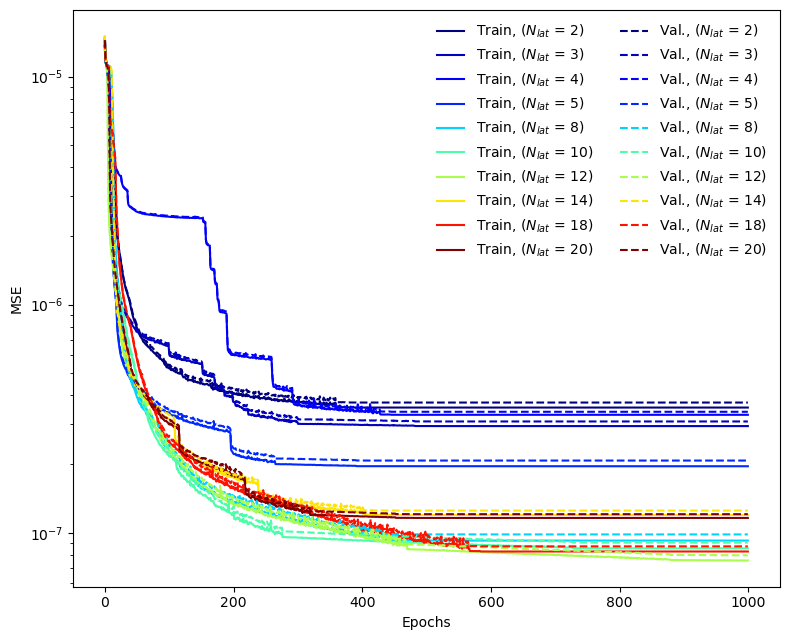

In [14]:
trainloss = []
valloss = []

fig = plt.figure(figsize=(8,6.5))
norm = matplotlib.colors.Normalize(vmin=2.0, vmax=20.0)
cols = cm.jet(norm(nlat),bytes=True)/256
#print(cols)
for i in range(0,len(nlat)):
    j = nlat[i]
    fnloss = 'IDModels/AE_z{}_mse_1000epochs_losses_updatedata.npz'.format(j)
    
    loss = np.load(fnloss)
    trainloss.append(loss['trainl'])
    valloss.append(loss['vall'])
    
    plt.plot(trainloss[i],label=r"Train, ($N_{lat}$ = "+str(j)+")",c = tuple(cols[i]))
for i in range(0,len(nlat)):
    j = nlat[i]
    fnloss = 'IDModels/AE_z{}_mse_1000epochs_losses_updatedata.npz'.format(j)
    
    loss = np.load(fnloss)
    trainloss.append(loss['trainl'])
    valloss.append(loss['vall'])
    
    plt.plot(valloss[i],label=r"Val., ($N_{lat}$ = "+str(j)+")", linestyle='dashed',c = tuple(cols[i]))
    
#plt.legend(bbox_to_anchor=(1.0, 0.95),ncol=2,frameon=False)
plt.legend(loc='upper right',ncol=2,frameon=False)
plt.yscale('log')
plt.ylabel("MSE")
plt.xlabel("Epochs")
#plt.show()
plt.tight_layout()
plt.savefig("MSELoss_nlat_AE_sc.png")

In [15]:
def latentvars(model,dataloader,device,nlatent=12):
    dataset = dataloader.dataset
    bs = 500
    nmoments = 4
    nmoms2 = 3
    nrates = 3


    latents = np.zeros((len(dataset),nlatent))
    moments = np.zeros((len(dataset),nmoments,nrates))
    rates = np.zeros((len(dataset),nmoments,nrates))
    M1s = np.zeros((len(dataset),nmoments,nrates))
    dM1dts = np.zeros((len(dataset),nmoments,nrates))
    M2s = np.zeros((len(dataset),nmoms2,nrates,2))
    dM2dts = np.zeros((len(dataset),nmoms2,nrates,2))

    jj = 0
    i = 0
    for data in dataloader:
        #M,dMdt,bin0,bin1coal,bin1condevap,M1,dM1dt,M2,dM2dt=data
        #M,dMdt,bin0,bin1coal,bin1condevap,binmag,M1,dM1dt,M2,dM2dt=data
        M,dMdt,bin0,bin1coal,bin1condevap,binmag,M1,dM1dt,M2,dM2dt=data
        bin1 = bin1coal.to(device)
        bin0 = bin0.to(device)
        #print(M.shape,M2.shape,dM2dt.shape)
        # z, mu, logvar
        xhat,latent = model(bin0.float())
        #print(latent.shape)
        #print(out[0].shape)
        bs = xhat.shape[0]
        #print(bs)
        if bs>0:
            latents[jj:jj+bs,:]=latent.detach().cpu().numpy().reshape(bs,nlatent)
            moments[jj:jj+bs,:,:]=M.cpu().numpy().reshape(bs,nmoments,nrates)
            rates[jj:jj+bs,:,:]=dMdt.cpu().numpy().reshape(bs,nmoments,nrates)
            M1s[jj:jj+bs,:]=M1.cpu().numpy().reshape(bs,nmoments,nrates)
            dM1dts[jj:jj+bs,:]=dM1dt.cpu().numpy().reshape(bs,nmoments,nrates)
            M2s[jj:jj+bs,:]=M2.cpu().numpy().reshape(bs,nmoms2,nrates,2)
            dM2dts[jj:jj+bs,:]=dM2dt.cpu().numpy().reshape(bs,nmoms2,nrates,2)
            jj=jj+bs
            i = i+1
        else:
            break
        #trainlatentvar,trainmoments,trainrates,trainM1,traindM1dt,trainM2,traindM2dt
    return latents,moments,rates,M1s,dM1dts,M2s,dM2dts

In [16]:
def remove_duplicates(X):
    return np.unique(X, axis=0)

In [17]:
def kNN(X, n_neighbors, n_jobs):
    neigh = NearestNeighbors(n_neighbors=n_neighbors, n_jobs=n_jobs).fit(X)
    dists, inds = neigh.kneighbors(X)
    return dists, inds
def Levina_Bickel(X, dists, k):
    m = np.log(dists[:, k:k+1] / dists[:, 1:k])
    m = (k-2) / np.sum(m, axis=1)
    dim = np.mean(m)
    return dim
def MiND_MLk(X,dists,k):
    ss = MiND_ML(k=k,ver="MLk")
    
    return ss.fit_transform(X)
def MiND_MLi(X,dists,k):
    ss = MiND_ML(k=k,ver="MLi")
    
    return ss.fit_transform(X)
def DimfromAngleNormConc(X,dists,k):
    ss = DANCo(k=k,ver="DANCo")
    
    return ss.fit_transform(X)
def MethodofMoments(X,dists,k):
    ss = Mom()
    
    return ss.fit_transform(X)

In [18]:
k_list = (latent.shape[0] * np.linspace(0.008, 0.016, 5)).astype('int')

In [19]:
# get the k nearest neighbors (for the Levina-Bickel algorithm calculation)
if np.isscalar(k_list):
    k_list = np.array([k_list])
else:
    k_list = np.array(k_list)
kmax = np.max(k_list) + 2
n_jobs=4
dists, inds = kNN(latent.detach().numpy(), kmax,n_jobs)
dims = []

In [20]:
nlat = [3,4,5,8,10,14,18,20]

In [22]:
i = 0
j = nlat[i]
model = MicroAutoEncoder(n_latent=j)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.to(device)
savedmodelweights = 'IDModels/AE_z{}_mse_1000epochs_updatedata'.format(j)

model.load_state_dict(torch.load(savedmodelweights,map_location=device))

vallatentvar,valmoments,valrates,M1s,dM1dts,M2s,dM2dts = latentvars(model,valloader,device,nlatent=j)

latent = vallatentvar

print(f'Number of samples: {latent.shape}; Latent dimension: {latent.shape[1]}')

latent = remove_duplicates(latent)
print(f'Number of samples (duplicates removed): {latent.shape[0]}')

#k_list = (latent.shape[0] * np.linspace(0.008, 0.016, 5)).astype('int')

#k_list = [100, 200, 500, 1000, 2000]
k_list = np.linspace(10,100,10).astype('int')

# get the k nearest neighbors (for the Levina-Bickel algorithm calculation)
if np.isscalar(k_list):
    k_list = np.array([k_list])
else:
    k_list = np.array(k_list)
kmax = np.max(k_list) + 2
n_jobs=4
dists, inds = kNN(latent, kmax,n_jobs)
dims = []
dims2 = []
for k in k_list:
    dims.append(Levina_Bickel(latent, dists, k))
    dims2.append(MiND_MLk(latent,dists,k))


Number of samples: (26000, 3); Latent dimension: 3
Number of samples (duplicates removed): 26000


In [23]:
def get_id_estimates(nlats):
    nmeth = 4
    val_ids = np.zeros((len(nlats),nmeth))
    val_ids_sdev = np.zeros((len(nlats),nmeth))
    
    for i in range(0,len(nlats)):
        j = nlats[i]
        model = MicroAutoEncoder(n_latent=j)

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        model = model.to(device)

        savedmodelweights = 'IDModels/AE_z{}_mse_1000epochs_updatedata'.format(j)
        model.load_state_dict(torch.load(savedmodelweights,map_location=device))
        
        vallatentvar,valmoments,valrates,M1s,dM1dts,M2s,dM2dts = latentvars(model,valloader,device,nlatent=j)
        
        latent = vallatentvar
        print(f'Number of samples: {latent.shape}; Latent dimension: {latent.shape[1]}')
        
        latent = remove_duplicates(latent)
        print(f'Number of samples (duplicates removed): {latent.shape[0]}')
        
        k_list = np.linspace(10,100,20).astype('int')
        
        # get the k nearest neighbors (for the Levina-Bickel algorithm calculation)
        if np.isscalar(k_list):
            k_list = np.array([k_list])
        else:
            k_list = np.array(k_list)
        kmax = np.max(k_list) + 2
        n_jobs=4
        dists, inds = kNN(latent, kmax,n_jobs)
        dims = []
        dims_DANCo = []
        dims_MiND_MLk = []
        dims_MiND_MLi = []
        print("Levina Bickel")
        for k in k_list:
            dims.append(Levina_Bickel(latent, dists, k))

        
        print("MiND MLk")
        for k in k_list:
            dims_MiND_MLk.append(MiND_MLk(latent,dists,k))
        
        print("MiND MLi")
        for k in k_list:
            dims_MiND_MLi.append(MiND_MLi(latent,dists,k))
            
        val_ids[i,0] = np.mean(dims)
        val_ids_sdev[i,0]=np.std(dims)
        
        ss = MOM()
        val_ids[i,1] = ss.fit_transform(latent) #np.mean(dims_DANCo)
        val_ids_sdev[i,1]= 0 #np.std(dims_DANCo)
        
        val_ids[i,2] = np.mean(dims_MiND_MLk)
        val_ids_sdev[i,2]=np.std(dims_MiND_MLk)
        
        val_ids[i,3] = np.mean(dims_MiND_MLi)
        val_ids_sdev[i,3]=np.std(dims_MiND_MLi)
        
    return val_ids,val_ids_sdev

In [24]:
val_ids,val_ids_sdev = get_id_estimates(nlat)

Number of samples: (26000, 3); Latent dimension: 3
Number of samples (duplicates removed): 26000
Levina Bickel
MiND MLk
MiND MLi
Number of samples: (26000, 4); Latent dimension: 4
Number of samples (duplicates removed): 26000
Levina Bickel
MiND MLk
MiND MLi
Number of samples: (26000, 5); Latent dimension: 5
Number of samples (duplicates removed): 26000
Levina Bickel
MiND MLk
MiND MLi
Number of samples: (26000, 8); Latent dimension: 8
Number of samples (duplicates removed): 26000
Levina Bickel
MiND MLk
MiND MLi
Number of samples: (26000, 10); Latent dimension: 10
Number of samples (duplicates removed): 26000
Levina Bickel
MiND MLk
MiND MLi
Number of samples: (26000, 14); Latent dimension: 14
Number of samples (duplicates removed): 26000
Levina Bickel
MiND MLk
MiND MLi
Number of samples: (26000, 18); Latent dimension: 18
Number of samples (duplicates removed): 26000
Levina Bickel
MiND MLk
MiND MLi
Number of samples: (26000, 20); Latent dimension: 20
Number of samples (duplicates removed)

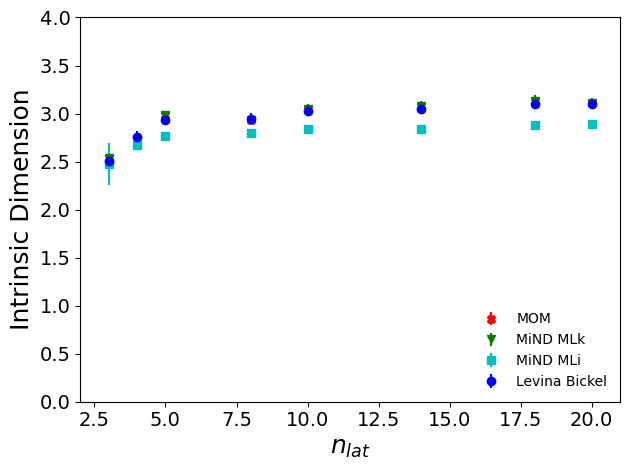

In [25]:
plt.errorbar(nlat,val_ids[:,1], yerr=val_ids_sdev[:,1], fmt="o",c='r',marker="X",label="MOM")
plt.errorbar(nlat,val_ids[:,1], yerr=val_ids_sdev[:,2], fmt="o",c='g',marker="v",label="MiND MLk")
plt.errorbar(nlat,val_ids[:,2], yerr=val_ids_sdev[:,3], fmt="o",c='c',marker='s',label="MiND MLi")
plt.errorbar(nlat,val_ids[:,0], yerr=val_ids_sdev[:,0], fmt="o",c='b',label="Levina Bickel")
plt.ylabel("Intrinsic Dimension",fontsize=18)
plt.xlabel(r"$n_{lat}$",fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim((2,21))
plt.ylim((0,4))
plt.tight_layout()
plt.legend(frameon=False,loc="lower right")
plt.savefig("ID_calc_comparison_updateddata.png",dpi=300)